In [123]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import seaborn as sns
import itertools
from scipy.linalg import block_diag
import time
import os
import pickle
from scipy.misc import comb
from functools import partial
from itertools import combinations

In [2]:
from __future__ import print_function

import sys

import cplex
from cplex.exceptions import CplexError

In [3]:
sushi_score = np.loadtxt('./sushi3-2016/sushi3b.5000.10.score')

In [4]:
print(sushi_score[0])
print(np.where(sushi_score[0]!=-1))

[-1.  0. -1.  4.  2. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  4. -1.  2. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1.
 -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  2. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(array([ 1,  3,  4, 12, 44, 58, 60, 67, 74, 87]),)


In [64]:
sushi_order = np.loadtxt('./sushi3-2016/sushi3b.5000.10.order', skiprows=1)
flips = []
for s in range(len(sushi_order)):
    rating = sorted(zip(np.take(sushi_score[s], np.where(sushi_score[s]!=-1)[0]), np.where(sushi_score[s]!=-1)[0]), reverse=True)
    ranking = sushi_order[s][2:]
    flips.append(countflips(ranking,rating))

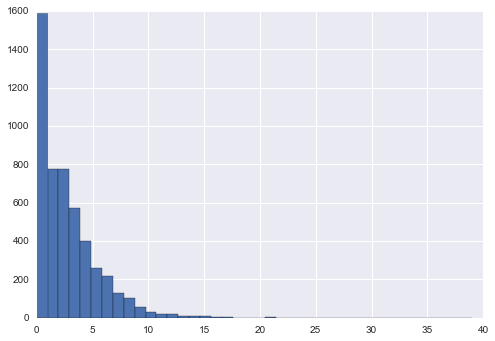

In [68]:
plt.hist(flips, bins=40)
plt.show()

In [100]:
unique, counts = np.unique(flips, return_counts=True)
print(np.array(counts).astype(float)/np.sum(counts))
print(unique)
distribution = (np.cumsum(np.array(counts).astype(float)/np.sum(counts)))
print(distribution)
with open('./dist.p','wb') as file_:
    pickle.dump(distribution, file_)
with open('./error_nums.p', 'wb') as file_:
    pickle.dump(unique, file_)

[  3.17200000e-01   1.55400000e-01   1.54800000e-01   1.14600000e-01
   7.96000000e-02   5.24000000e-02   4.34000000e-02   2.58000000e-02
   2.08000000e-02   1.16000000e-02   6.00000000e-03   3.80000000e-03
   4.40000000e-03   2.20000000e-03   1.60000000e-03   2.20000000e-03
   1.20000000e-03   4.00000000e-04   2.00000000e-04   4.00000000e-04
   2.00000000e-04   2.00000000e-04   2.00000000e-04   2.00000000e-04
   2.00000000e-04   2.00000000e-04   2.00000000e-04   2.00000000e-04
   2.00000000e-04   2.00000000e-04]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 27 28
 30 31 32 33 39]
[ 0.3172  0.4726  0.6274  0.742   0.8216  0.874   0.9174  0.9432  0.964
  0.9756  0.9816  0.9854  0.9898  0.992   0.9936  0.9958  0.997   0.9974
  0.9976  0.998   0.9982  0.9984  0.9986  0.9988  0.999   0.9992  0.9994
  0.9996  0.9998  1.    ]


In [58]:
print(rating)
print(ranking)

[(4.0, 58), (4.0, 3), (2.0, 87), (2.0, 60), (2.0, 4), (1.0, 44), (1.0, 12), (0.0, 74), (0.0, 67), (0.0, 1)]
[ 58.   4.   3.  44.  87.  60.  67.   1.  12.  74.]


In [91]:
sushi_order_small = np.loadtxt('./sushi3-2016/sushi3a.5000.10.order', skiprows=1)
print(len(sushi_order_small))

5000


In [116]:
def generate_correct_profiles(num_voters, num_profiles):
    profiles = []
    for i in range(num_profiles):
        profiles.append(np.array([list(x[2:]) for x in sushi_order_small[np.random.choice(5000,num_voters)] +1]))
    return profiles

In [135]:
def induce_errors(profiles):
    error_profiles = np.copy(profiles)
    with open('./dist.p','rb') as file_:
        distribution = pickle.load(file_)
    with open('./error_nums.p', 'rb') as file_:
        error_nums = pickle.load(file_)
    for i in range(len(error_profiles)):
        for j in range(len(error_profiles[i])):
#             print(profiles[i][j])
            draw = np.random.uniform(0,1)
            errors = error_nums[np.min(np.where(distribution>draw)[0])]
            indices = np.random.choice(range(9),errors)
            for k in indices:
                tmp = error_profiles[i][j][k]
                error_profiles[i][j][k] = error_profiles[i][j][k+1]
                error_profiles[i][j][k+1] = tmp
#             print (profiles[i][j])
    return error_profiles

In [118]:
def simulate_voting(profile, size_subset):
    num_voters = 20
    
    n,m = len(profile), len(profile[0])
    k=size_subset

    def Ind(m,k,i,r):
        return (i-1)*(m-k+1)+r+m
    IndY = partial(Ind,m,k)
    # IndY(1,1)

    nIneq  = int(n*((m-k+2)*(m-k+3)/2-1)+comb(m,k))
    nEq = 1
    nVar = int(m+n*(m-k+1)+1)
    Aineq = np.zeros((nIneq, nVar))
    bineq = np.zeros((nIneq, 1))
    Aeq = np.zeros((nEq, nVar))
    beq = np.zeros((nEq, 1))
    f = np.zeros((nVar, 1))
    ctype = 'B'*(nVar-1)+'C'
    f[-1] = 1
    Aeq[0][0:m] = 1
    beq = k
    countIneq = 1

    for i in range(1,n+1):
        for r in range(1,m-k+2):
            for j in range(1,r+1):
                Aineq[countIneq-1, IndY(i,r)-1] = 1
                Aineq[countIneq-1, profile[i-1,j-1]-1] = 1
                bineq[countIneq-1] = 1
                countIneq = countIneq + 1
            Aineq[countIneq-1, IndY(i,r)-1] = -1
            for j in range(1,r+1):
                Aineq[countIneq-1, profile[i-1,j-1]-1] = -1
            bineq[countIneq-1] = -1
            countIneq = countIneq + 1
    list_T = np.array([list(int(y)+1 for y in x) for x in list(combinations(range(m),k))])
    for indT in range(1, list_T.shape[0]+1):
        T = list_T[indT-1]
        first_indices_T = np.array([[i for i,elem in enumerate(x) if x[i] in T][0] + 1 for x in profile])
        Aineq[countIneq-1, nVar-1] = -1
        for i in range(1,n+1):
            Aineq[countIneq-1,IndY(i,first_indices_T[i-1])-1] = 1./first_indices_T[i-1]
        countIneq = countIneq + 1

    # data common to all populateby functions
    my_obj = list(i[0] for i in f)
    my_ub = [cplex.infinity]*len(f)
    my_lb = [0.0]*len(f)
    my_ctype = ctype
    my_colnames = ['x{}'.format(i) for i in range(len(f))]
    my_rhs = list(i[0] for i in bineq) + [float(beq)]
    my_rownames = ['r{}'.format(i) for i in range(nIneq+nEq)]
    my_sense = 'L'*nIneq+'E'*nEq

    def populatebynonzero(prob):
        prob.objective.set_sense(prob.objective.sense.minimize)

        prob.linear_constraints.add(rhs=my_rhs, senses=my_sense,
                                    names=my_rownames)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype,
                           names=my_colnames)

        rows, cols = np.nonzero(np.concatenate((Aineq,Aeq)))
        rows=list(rows)
        cols=list(cols)
        vals = [np.concatenate((Aineq,Aeq))[rows[i],cols[i]] for i in range(len(rows))]

        prob.linear_constraints.set_coefficients(zip(rows, cols, vals))


    def mipex1(pop_method):

        try:
            my_prob = cplex.Cplex()

            handle = populatebynonzero(my_prob)

            my_prob.solve()
        except CplexError as exc:
            print(exc)
            return

#         print()
#         # solution.get_status() returns an integer code
#         print("Solution status = ", my_prob.solution.get_status(), ":", end=' ')
#         # the following line prints the corresponding string
#         print(my_prob.solution.status[my_prob.solution.get_status()])
#         print("Solution value  = ", my_prob.solution.get_objective_value())

        numcols = my_prob.variables.get_num()
        numrows = my_prob.linear_constraints.get_num()

        slack = my_prob.solution.get_linear_slacks()
        x = my_prob.solution.get_values()

    #     for j in range(numrows):
    #         print("Row %d:  Slack = %10f" % (j, slack[j]))
        for j in range(m):
            print("Column %d:  Value = %10f" % (j, x[j]))
        print ("Column %d:  Value = %10f" % (numcols-1, x[numcols-1]))
        return x[:10]

    choices = mipex1('n')
    print (list((np.array(np.where(np.array(choices)>0.0))+1)[0]))
    selected_points = list((np.array(np.where(np.array(choices)>0.5))+1)[0])
    return selected_points

In [119]:
def countflips(ranking, rating):
    counter = 0
    i=0
    while i<len(ranking):
        if ranking[i]==rating[i][1]:
            i+=1
        else:
            j = np.where([x[1] for x in rating]==ranking[i])[0][0]
#             print(j)
            for k in range(j,i,-1):
                tmp = rating[k-1]
                rating[k-1] = rating[k]
                rating[k] = tmp
                if rating[k][0]!=rating[k-1][0]:
                    counter+=1
#                     print("adding 1")
#                 print (ranking[k],ranking[k-1])
#                 print (rating[k],rating[k-1])
#             print (rating)
#             print (ranking)
#             print (counter)
            i+=1
    return counter

In [136]:
profiles = generate_correct_profiles(10,10)
other_profiles = induce_errors(profiles)
correct_subsets = []
error_subsets = []
for i in range(len(profiles)):
    correct_subsets.append(simulate_voting(profiles[i],3))
    error_subsets.append(simulate_voting(other_profiles[i],3))

CPXPARAM_Read_DataCheck                          1
CPXPARAM_Read_APIEncoding                        "UTF-8"
CPXPARAM_MIP_Strategy_CallbackReducedLP          0


/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Tried aggregator 2 times.
MIP Presolve eliminated 34 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 517 rows, 81 columns, and 2087 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.69 ticks)
Found incumbent of value 7.000000 after 0.01 sec. (3.02 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.54 ticks)
Cover probing fixed 0 vars, tightened 16 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 212 rows and 27 columns.
MIP Presolve modified 16 coefficients.
Reduced MIP has 305 rows, 54 columns, and 1446 nonzeros.
Reduced MIP has 53 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.75 ticks)
Probing fixed 23 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.23 ticks)
Cover probing fixed 0 vars, tightened 6 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 122 rows and 23 columns.
MIP Presolve modified 40 coefficients.
Reduced MIP has 183 

Tried aggregator 2 times.
MIP Presolve eliminated 32 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 519 rows, 81 columns, and 2098 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.71 ticks)
Found incumbent of value 7.000000 after 0.02 sec. (3.03 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.67 ticks)
Cover probing fixed 0 vars, tightened 14 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 197 rows and 25 columns.
MIP Presolve modified 27 coefficients.
Reduced MIP has 322 rows, 56 columns, and 1513 nonzeros.
Reduced MIP has 55 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.86 ticks)
Probing fixed 22 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.62 ticks)
Cover probing fixed 0 vars, tightened 3 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 143 rows and 24 columns.
MIP Presolve modified 12 coefficients.
Reduced MIP has 179 

Tried aggregator 2 times.
MIP Presolve eliminated 18 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 533 rows, 81 columns, and 2271 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.83 ticks)
Found incumbent of value 5.500000 after 0.02 sec. (3.17 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.43 ticks)
Cover probing fixed 0 vars, tightened 14 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 204 rows and 29 columns.
MIP Presolve modified 11 coefficients.
Reduced MIP has 329 rows, 52 columns, and 1624 nonzeros.
Reduced MIP has 51 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.10 ticks)
Probing fixed 18 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.84 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 143 rows and 22 columns.
MIP Presolve modified 5 coefficients.
Reduced MIP has 186 rows, 30 columns, and 965 nonzeros.
Reduced MIP h

Tried aggregator 2 times.
MIP Presolve eliminated 18 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 533 rows, 81 columns, and 2271 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.84 ticks)
Found incumbent of value 5.500000 after 0.02 sec. (3.18 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.44 ticks)
Cover probing fixed 0 vars, tightened 14 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 195 rows and 26 columns.
MIP Presolve modified 11 coefficients.
Reduced MIP has 338 rows, 55 columns, and 1673 nonzeros.
Reduced MIP has 54 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.15 ticks)
Probing fixed 18 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.06 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 154 rows and 25 columns.
MIP Presolve modified 5 coefficients.
Reduced MIP has 184 rows, 30 columns, and 949 nonzeros.
Reduced MIP h

Tried aggregator 2 times.
MIP Presolve eliminated 21 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 530 rows, 81 columns, and 2210 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.79 ticks)
Found incumbent of value 6.000000 after 0.01 sec. (3.12 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.10 ticks)
Cover probing fixed 0 vars, tightened 12 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 188 rows and 24 columns.
MIP Presolve modified 14 coefficients.
Reduced MIP has 342 rows, 57 columns, and 1656 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.07 ticks)
Probing fixed 11 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.36 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 105 rows and 19 columns.
MIP Presolve modified 10 coefficients.
Reduced MIP has 237 

Tried aggregator 2 times.
MIP Presolve eliminated 22 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 529 rows, 81 columns, and 2195 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.78 ticks)
Found incumbent of value 5.000000 after 0.01 sec. (3.11 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.06 ticks)
Cover probing fixed 0 vars, tightened 15 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 199 rows and 25 columns.
MIP Presolve modified 17 coefficients.
Reduced MIP has 330 rows, 56 columns, and 1603 nonzeros.
Reduced MIP has 55 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.02 ticks)
Probing fixed 26 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.13 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 195 rows and 34 columns.
MIP Presolve modified 35 coefficients.
Reduced MIP has 135 

Tried aggregator 2 times.
MIP Presolve eliminated 25 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 526 rows, 81 columns, and 2130 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.77 ticks)
Found incumbent of value 8.000000 after 0.01 sec. (3.10 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.98 ticks)
Cover probing fixed 0 vars, tightened 10 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 165 rows and 20 columns.
MIP Presolve modified 26 coefficients.
Reduced MIP has 361 rows, 61 columns, and 1635 nonzeros.
Reduced MIP has 60 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.16 ticks)
Probing fixed 7 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.25 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 55 rows and 8 columns.
MIP Presolve modified 2 coefficients.
Reduced MIP has 306 rows

Tried aggregator 2 times.
MIP Presolve eliminated 22 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 529 rows, 81 columns, and 2193 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.81 ticks)
Found incumbent of value 7.000000 after 0.01 sec. (3.14 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.28 ticks)
Cover probing fixed 0 vars, tightened 13 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 191 rows and 24 columns.
MIP Presolve modified 24 coefficients.
Reduced MIP has 338 rows, 57 columns, and 1613 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.09 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.24 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 106 rows and 18 columns.
MIP Presolve modified 7 coefficients.
Reduced MIP has 232 r

Tried aggregator 2 times.
MIP Presolve eliminated 11 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 540 rows, 81 columns, and 2332 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.84 ticks)
Found incumbent of value 6.500000 after 0.01 sec. (3.19 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.36 ticks)
Cover probing fixed 0 vars, tightened 8 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 148 rows and 20 columns.
MIP Presolve modified 3 coefficients.
Reduced MIP has 392 rows, 61 columns, and 1879 nonzeros.
Reduced MIP has 60 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.46 ticks)
Probing fixed 3 vars, tightened 0 bounds.
Probing time = 0.01 sec. (2.45 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 25 rows and 4 columns.
Reduced MIP has 367 rows, 57 columns, and 1786 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 

Tried aggregator 2 times.
MIP Presolve eliminated 12 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 539 rows, 81 columns, and 2323 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.85 ticks)
Found incumbent of value 6.500000 after 0.02 sec. (3.20 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.32 ticks)
Cover probing fixed 0 vars, tightened 8 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 149 rows and 20 columns.
MIP Presolve modified 7 coefficients.
Reduced MIP has 390 rows, 61 columns, and 1838 nonzeros.
Reduced MIP has 60 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.42 ticks)
Probing fixed 3 vars, tightened 0 bounds.
Probing time = 0.01 sec. (2.20 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 19 rows and 3 columns.
Reduced MIP has 371 rows, 58 columns, and 1758 nonzeros.
Reduced MIP has 57 binaries, 0 generals, 0 SOSs, and 0 

Tried aggregator 2 times.
MIP Presolve eliminated 11 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 540 rows, 81 columns, and 2331 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.81 ticks)
Found incumbent of value 6.500000 after 0.01 sec. (3.15 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.18 ticks)
Cover probing fixed 0 vars, tightened 6 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 125 rows and 15 columns.
MIP Presolve modified 7 coefficients.
Reduced MIP has 415 rows, 66 columns, and 1980 nonzeros.
Reduced MIP has 65 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.57 ticks)
Probing fixed 2 vars, tightened 0 bounds.
Probing time = 0.01 sec. (2.33 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 16 rows and 2 columns.
Reduced MIP has 399 rows, 64 columns, and 1908 nonzeros.
Reduced MIP has 63 binaries, 0 generals, 0 SOSs, and 0 

Tried aggregator 2 times.
MIP Presolve eliminated 12 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 539 rows, 81 columns, and 2320 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.81 ticks)
Found incumbent of value 6.500000 after 0.02 sec. (3.16 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.18 ticks)
Cover probing fixed 0 vars, tightened 7 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 139 rows and 17 columns.
MIP Presolve modified 8 coefficients.
Reduced MIP has 400 rows, 64 columns, and 1920 nonzeros.
Reduced MIP has 63 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.47 ticks)
Probing fixed 2 vars, tightened 0 bounds.
Probing time = 0.00 sec. (2.14 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 14 rows and 2 columns.
Reduced MIP has 386 rows, 62 columns, and 1864 nonzeros.
Reduced MIP has 61 binaries, 0 generals, 0 SOSs, and 0 

Tried aggregator 2 times.
MIP Presolve eliminated 18 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 533 rows, 81 columns, and 2191 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.29 sec. (2.76 ticks)
Found incumbent of value 7.000000 after 0.29 sec. (3.09 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.76 ticks)
Cover probing fixed 0 vars, tightened 11 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 177 rows and 23 columns.
MIP Presolve modified 12 coefficients.
Reduced MIP has 356 rows, 58 columns, and 1588 nonzeros.
Reduced MIP has 57 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.08 ticks)
Probing fixed 16 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.66 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 104 rows and 16 columns.
MIP Presolve modified 9 coefficients.
Reduced MIP has 252 rows, 42 columns, and 1121 nonzeros.
Reduced MIP 

Tried aggregator 2 times.
MIP Presolve eliminated 19 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 532 rows, 81 columns, and 2182 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.75 ticks)
Found incumbent of value 6.000000 after 0.02 sec. (3.08 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.72 ticks)
Cover probing fixed 0 vars, tightened 14 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 194 rows and 26 columns.
MIP Presolve modified 63 coefficients.
Reduced MIP has 338 rows, 55 columns, and 1540 nonzeros.
Reduced MIP has 54 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.97 ticks)
Probing fixed 18 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.41 ticks)
Cover probing fixed 0 vars, tightened 10 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 122 rows and 18 columns.
MIP Presolve modified 32 coefficients.
Reduced MIP has 216

Tried aggregator 2 times.
MIP Presolve eliminated 28 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 523 rows, 81 columns, and 2123 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.73 ticks)
Found incumbent of value 6.000000 after 0.02 sec. (3.05 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.73 ticks)
Cover probing fixed 0 vars, tightened 14 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 179 rows and 22 columns.
MIP Presolve modified 29 coefficients.
Reduced MIP has 344 rows, 59 columns, and 1588 nonzeros.
Reduced MIP has 58 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.03 ticks)
Probing fixed 15 vars, tightened 0 bounds.
Probing time = 0.01 sec. (2.20 ticks)
Cover probing fixed 0 vars, tightened 8 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 113 rows and 19 columns.
MIP Presolve modified 24 coefficients.
Reduced MIP has 231 

Tried aggregator 2 times.
MIP Presolve eliminated 26 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 525 rows, 81 columns, and 2140 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.72 ticks)
Found incumbent of value 6.000000 after 0.02 sec. (3.05 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.73 ticks)
Cover probing fixed 0 vars, tightened 14 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 186 rows and 23 columns.
MIP Presolve modified 21 coefficients.
Reduced MIP has 339 rows, 58 columns, and 1582 nonzeros.
Reduced MIP has 57 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.00 ticks)
Probing fixed 13 vars, tightened 0 bounds.
Probing time = 0.01 sec. (2.14 ticks)
Cover probing fixed 0 vars, tightened 5 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 98 rows and 16 columns.
MIP Presolve modified 20 coefficients.
Reduced MIP has 241 r

Tried aggregator 2 times.
MIP Presolve eliminated 21 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 530 rows, 81 columns, and 2206 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.82 ticks)
Found incumbent of value 6.000000 after 0.01 sec. (3.15 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (4.05 ticks)
Cover probing fixed 0 vars, tightened 15 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 205 rows and 26 columns.
MIP Presolve modified 15 coefficients.
Reduced MIP has 325 rows, 55 columns, and 1535 nonzeros.
Reduced MIP has 54 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.03 ticks)
Probing fixed 17 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.74 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 122 rows and 18 columns.
MIP Presolve modified 6 coefficients.
Reduced MIP has 203 rows, 37 columns, and 950 nonzeros.
Reduced MIP h

Tried aggregator 2 times.
MIP Presolve eliminated 25 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 526 rows, 81 columns, and 2136 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.77 ticks)
Found incumbent of value 7.000000 after 0.02 sec. (3.10 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.77 ticks)
Cover probing fixed 0 vars, tightened 14 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 198 rows and 24 columns.
MIP Presolve modified 18 coefficients.
Reduced MIP has 328 rows, 57 columns, and 1506 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.96 ticks)
Probing fixed 11 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.76 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 83 rows and 13 columns.
MIP Presolve modified 8 coefficients.
Reduced MIP has 245 rows, 44 columns, and 1076 nonzeros.
Reduced MIP h

Tried aggregator 2 times.
MIP Presolve eliminated 39 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 512 rows, 81 columns, and 2052 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.65 ticks)
Found incumbent of value 6.000000 after 0.01 sec. (2.96 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.29 ticks)
Cover probing fixed 0 vars, tightened 17 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 423 rows and 58 columns.
MIP Presolve modified 76 coefficients.
Reduced MIP has 89 rows, 23 columns, and 332 nonzeros.
Reduced MIP has 21 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.45 ticks)
Probing fixed 4 vars, tightened 0 bounds.
Probing changed sense of 8 constraints.
Probing time = 0.00 sec. (0.23 ticks)
Cover probing fixed 0 vars, tightened 2 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 70 rows and 12 columns.
MIP Presolve modified 3

Tried aggregator 2 times.
MIP Presolve eliminated 30 rows and 0 columns.
Aggregator did 10 substitutions.
Reduced MIP has 521 rows, 81 columns, and 2150 nonzeros.
Reduced MIP has 80 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.69 ticks)
Found incumbent of value 7.000000 after 0.02 sec. (3.02 ticks)
Probing fixed 10 vars, tightened 0 bounds.
Probing time = 0.01 sec. (3.65 ticks)
Cover probing fixed 0 vars, tightened 16 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 214 rows and 27 columns.
MIP Presolve modified 2 coefficients.
Reduced MIP has 307 rows, 54 columns, and 1487 nonzeros.
Reduced MIP has 53 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.82 ticks)
Probing fixed 14 vars, tightened 0 bounds.
Probing time = 0.01 sec. (2.09 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 173 rows and 31 columns.
MIP Presolve modified 2 coefficients.
Reduced MIP has 134 rows, 23 columns, and 670 nonzeros.
Reduced MIP ha

In [137]:
correct_subsets

[[2, 5, 8],
 [2, 4, 8],
 [2, 6, 8],
 [2, 5, 8],
 [5, 6, 8],
 [4, 5, 6],
 [2, 3, 5],
 [2, 7, 8],
 [1, 3, 8],
 [3, 5, 8]]

In [138]:
error_subsets

[[1, 3, 8],
 [2, 4, 8],
 [2, 6, 8],
 [5, 6, 8],
 [5, 6, 8],
 [3, 5, 6],
 [1, 2, 5],
 [2, 3, 8],
 [1, 3, 8],
 [3, 5, 8]]

In [139]:
profiles[0]

array([[  8.,   5.,   2.,   1.,   6.,   9.,   3.,   4.,   7.,  10.],
       [  8.,   9.,   3.,   4.,   1.,  10.,   2.,   7.,   6.,   5.],
       [  8.,   6.,   5.,   1.,   3.,   2.,   7.,   9.,  10.,   4.],
       [  1.,   8.,   3.,   6.,   2.,   9.,   4.,   7.,  10.,   5.],
       [  8.,   2.,   1.,   3.,   6.,   5.,   9.,   7.,  10.,   4.],
       [  8.,   7.,   9.,   4.,   3.,   2.,  10.,   1.,   6.,   5.],
       [  2.,   1.,   4.,   6.,   3.,   8.,   9.,  10.,   7.,   5.],
       [  8.,   5.,   3.,   6.,   1.,   9.,   2.,   4.,   7.,  10.],
       [  5.,   8.,   3.,   1.,   6.,   4.,   9.,   7.,  10.,   2.],
       [  5.,   8.,   1.,   7.,   6.,   9.,   3.,   2.,   4.,  10.]])

In [140]:
other_profiles[0]

array([[  8.,   5.,   2.,   6.,   1.,   9.,   3.,   4.,   7.,  10.],
       [  8.,   3.,   9.,   4.,   1.,  10.,   7.,   2.,   6.,   5.],
       [  8.,   6.,   5.,   1.,   3.,   2.,   7.,   9.,  10.,   4.],
       [  1.,   8.,   3.,   6.,   2.,   9.,   4.,   7.,  10.,   5.],
       [  8.,   2.,   6.,   1.,   3.,  10.,   5.,   9.,   7.,   4.],
       [  8.,   7.,   9.,   4.,   3.,   2.,  10.,   1.,   6.,   5.],
       [  1.,   2.,   6.,   4.,   3.,   8.,   9.,  10.,   7.,   5.],
       [  8.,   5.,   3.,   6.,   1.,   9.,   2.,   4.,   7.,  10.],
       [  3.,   8.,   5.,   1.,   6.,   4.,   2.,   7.,   9.,  10.],
       [  5.,   1.,   8.,   7.,   6.,   3.,   2.,   9.,   4.,  10.]])

In [154]:
print([list(x[:3]) for x in profiles[0]])
vals, cnts = np.unique([list(x[:3]) for x in profiles[0]], return_counts=True)
print (vals, cnts)
print (sorted(zip(cnts,vals), reverse=True))
[z[1] for z in sorted(zip(cnts,vals), reverse=True)[:3]]

[[8.0, 5.0, 2.0], [8.0, 9.0, 3.0], [8.0, 6.0, 5.0], [1.0, 8.0, 3.0], [8.0, 2.0, 1.0], [8.0, 7.0, 9.0], [2.0, 1.0, 4.0], [8.0, 5.0, 3.0], [5.0, 8.0, 3.0], [5.0, 8.0, 1.0]]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9.] [4 3 4 1 5 1 1 9 2]
[(9, 8.0), (5, 5.0), (4, 3.0), (4, 1.0), (3, 2.0), (2, 9.0), (1, 7.0), (1, 6.0), (1, 4.0)]


[8.0, 5.0, 3.0]

In [158]:
correct_subsets_plurality = []
error_subsets_plurality = []
for i in range(len(profiles)):
    vals, cnts = np.unique([list(x[:3]) for x in profiles[i]], return_counts=True)
    correct_subsets_plurality.append([int(z[1]) for z in sorted(zip(cnts,vals), reverse=True)[:3]])
    vals, cnts = np.unique([list(x[:3]) for x in other_profiles[i]], return_counts=True)
    error_subsets_plurality.append([int(z[1]) for z in sorted(zip(cnts,vals), reverse=True)[:3]])

In [161]:
for i in range(10):
    print(correct_subsets_plurality[i], correct_subsets[i])

[8, 5, 3] [2, 5, 8]
[8, 5, 3] [2, 4, 8]
[6, 8, 2] [2, 6, 8]
[8, 5, 3] [2, 5, 8]
[8, 6, 5] [5, 6, 8]
[8, 5, 4] [4, 5, 6]
[8, 5, 3] [2, 3, 5]
[8, 2, 6] [2, 7, 8]
[8, 3, 2] [1, 3, 8]
[8, 2, 3] [3, 5, 8]


In [162]:
for i in range(10):
    print(error_subsets_plurality[i], error_subsets[i])

[8, 5, 3] [1, 3, 8]
[8, 5, 3] [2, 4, 8]
[6, 8, 5] [2, 6, 8]
[8, 5, 3] [5, 6, 8]
[8, 3, 6] [5, 6, 8]
[8, 2, 9] [3, 5, 6]
[5, 8, 3] [1, 2, 5]
[8, 6, 3] [2, 3, 8]
[8, 2, 3] [1, 3, 8]
[8, 2, 3] [3, 5, 8]


In [167]:
print("Robustness Plurality")
print(np.sum([set(correct_subsets_plurality[i])==set(error_subsets_plurality[i]) for i in range(10)]))
print("Robustness MinRegret")
print(np.sum([set(correct_subsets[i])==set(error_subsets[i]) for i in range(10)]))

Robustness Plurality
6
Robustness MinRegret
5
